In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from PIL import Image
from torchvision import transforms
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torchvision.models as models
from torch.nn import functional as F
from tqdm import tqdm

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 32
best_val_loss = float('inf')
patience = 5
counter = 0
save_path = "best_model 2.pt"
NUM_EPOCHS = 30
LR = 1e-4

cuda


In [10]:
def parse_qa_set(qa_pairs_txt_path):

    qa_set = []

    with open(qa_pairs_txt_path, 'r') as f:
        for line in f:
            elements = line.strip().split('|')
            if len(elements) > 3:
                image_id = elements[0]
                question = elements[2]
                answer = elements[3]
            else:
                image_id, question, answer = elements
            qa_set.append({
                'image_id': image_id,
                'question': question,
                'answer': answer
            })

    return len(qa_set), qa_set


In [11]:
class VQADataset(Dataset):
    def __init__(self, images_dir, qa_file, transform=None, tokenizer=None, max_len=32):
        """
        images_dir: director cu imagini (.jpg/.png)
        qa_file: JSON cu lista de dicturi: {"image_id": "...", "question": "...", "answer": "..."}
        transform: transformări torchvision pentru imagine
        tokenizer: funcție/tokenizator pentru întrebări
        max_len: lungimea maximă pentru tokenizare
        """
        self.images_dir = images_dir
        self.length, self.items = parse_qa_set(qa_file)
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        item = self.items[idx]
        img_path = self.images_dir + "/" + str(item['image_id']) + ".jpg"
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        question = item['question']
        if self.tokenizer:
            tokens = self.tokenizer(question, padding='max_length',
                                     truncation=True, max_length=self.max_len,
                                     return_tensors='pt')
            input_ids = tokens['input_ids'].squeeze(0)
            attention_mask = tokens['attention_mask'].squeeze(0)
        else:
            input_ids = question
            attention_mask = None

        answer = item['answer']
        
        ret = {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'answer': answer
        }
        
        if ret is None:
            print(f"Item at index {idx} is None. Check your dataset.")
        return ret


In [12]:
test_path = "/kaggle/input/medical-vqa-imageclef-2019/ImageClef-2019-VQA-Med/Test"
train_path = "/kaggle/input/medical-vqa-imageclef-2019/ImageClef-2019-VQA-Med/Training"
validation_path = "/kaggle/input/medical-vqa-imageclef-2019/ImageClef-2019-VQA-Med/Validation"

In [13]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer.pad_token = '[PAD]' # Set the pad token to avoid warnings
train_dataset = VQADataset(
    images_dir=f'{train_path}/images', 
    qa_file=f'{train_path}/all_qa_pairs.txt',

    tokenizer=tokenizer
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
)

val_dataset = VQADataset(
    images_dir=f'{validation_path}/images', 
    qa_file=f'{validation_path}/all_qa_pairs.txt',
    tokenizer=tokenizer
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
)

test_dataset = VQADataset(
    images_dir=f'{test_path}/images', 
    qa_file=f'{test_path}/questions_w_ref_answers.txt',
    tokenizer=tokenizer
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
)


In [14]:
class VisualEncoder(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()
        base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.features = base_model.features
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.projection = nn.Sequential(
            nn.Linear(1024, 768),
            nn.ReLU(),
            nn.Linear(768, embed_dim)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x).view(x.size(0), -1)
        x = self.projection(x)
        return x


In [15]:
class TextEncoder(nn.Module):
    def __init__(self, model_name='bert-base-uncased', embed_dim=512):
        super().__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        self.projection = nn.Sequential(
            nn.Linear(self.transformer.config.hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, embed_dim)
        )

    def forward(self, input_ids, attention_mask):
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = output.last_hidden_state[:, 0]  
        return self.projection(cls_token)


In [16]:
visual_encoder = VisualEncoder().to(device)
text_encoder = TextEncoder().to(device)

for batch in train_loader:
    images = batch["image"].to(device)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    img_emb = visual_encoder(images) 
    txt_emb = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
    print(img_emb.shape, txt_emb.shape)  
    break


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 247MB/s]
2026-02-08 11:34:56.418399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770550496.598323      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770550496.652362      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

torch.Size([32, 512]) torch.Size([32, 512])


In [17]:
class CrossAttentionFusion(nn.Module):
    def __init__(self, dim=512, heads=8):
        super().__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.norm = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.ReLU(),
            nn.Linear(dim * 2, dim)
        )

    def forward(self, text_embeds, image_embeds):
        """
        text_embeds: [B, T, D]     (token embeddings)
        image_embeds: [B, N, D]    (visual tokens)
        """
        attn_output, _ = self.cross_attn(query=text_embeds, key=image_embeds, value=image_embeds)
        x = self.norm(attn_output + text_embeds)
        x = self.mlp(x)
        return x 


In [18]:
fusion_layer = CrossAttentionFusion(dim=512).to(device)

for batch in train_loader:
    images = batch["image"].to(device)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    img_emb = visual_encoder(images)  # B x 512
    txt_emb = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
    fused_emb = fusion_layer(txt_emb.unsqueeze(1), img_emb.unsqueeze(1))  # [B, 1, 512]
    print(fused_emb.shape)  # Should be [B, 1, 512]
    break# B x 512


torch.Size([32, 1, 512])


In [19]:
class AnswerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, max_len=32, num_layers=4, nhead=8):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Embedding(max_len, embed_dim)
        self.transformer = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True),
            num_layers=num_layers
        )
        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.max_len = max_len
        self.embed_dim = embed_dim

    def forward(self, tgt_input_ids, memory, tgt_key_padding_mask=None):
        """
        tgt_input_ids: [B, T] 
        memory: [B, S, D] 
        """
        B, T = tgt_input_ids.size()
        device = tgt_input_ids.device

        pos_ids = torch.arange(T, device=device).unsqueeze(0).expand(B, -1)
        tgt_emb = self.token_emb(tgt_input_ids) + self.pos_emb(pos_ids)  # [B, T, D]

        causal_mask = torch.triu(torch.ones((T, T), device=device), diagonal=1).bool()

        out = self.transformer(
            tgt=tgt_emb,
            memory=memory,
            tgt_mask=causal_mask
        )  

        return self.fc_out(out)  
    


In [20]:
import torch
import torch.nn as nn

class VQAModel(nn.Module):
    def __init__(self, visual_encoder, text_encoder, fusion, decoder):
        super().__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.fusion = fusion
        self.decoder = decoder

    def forward(self, image, input_ids, attention_mask, decoder_input_ids):

        img_feat = self.visual_encoder(image)              

        text_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)

        fused = self.fusion(text_out, img_feat)       
        if fused.dim() == 2:
            fused = fused.unsqueeze(1)  
        logits = self.decoder(
        tgt_input_ids=decoder_input_ids,         
        memory=fused                             
        )   

        return logits



In [21]:


def train_vqa_model_epoch(model, dataloader, optimizer, tokenizer, device, max_len=32):
    cnt = 0
    model.train()
    total_loss = 0.0

    for batch in dataloader:
        if cnt % 20 == 0:
            print(f'{cnt} / {len(dataloader)}')
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        answers = batch['answer']  # listă de stringuri

        # Tokenizăm răspunsurile
        answer_tokens = tokenizer(answers, padding='max_length', truncation=True,
                                  max_length=max_len, return_tensors='pt')
        decoder_input_ids = answer_tokens['input_ids'][:, :-1].to(device)  # teacher forcing
        labels = answer_tokens['input_ids'][:, 1:].to(device)              # shifted

        # Forward
        logits = model(
            image=images,
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids
        )

        # Loss
        loss = F.cross_entropy(
            logits.reshape(-1, logits.size(-1)),
            labels.reshape(-1),
            ignore_index=tokenizer.pad_token_id
        )

        # Backprop + optimizare
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        cnt += 1

    avg_loss = total_loss / len(dataloader)
    return avg_loss




In [22]:
def validate_vqa_model_epoch(model, dataloader, tokenizer, device, max_len=32):
    model.eval()
    total_loss = 0.0
    cnt = 0
    with torch.no_grad():
        for batch in dataloader:
            if cnt % 20 == 0:
                print(f"{cnt} / {len(dataloader)}")
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            answers = batch['answer']

            answer_tokens = tokenizer(answers, padding='max_length', truncation=True,
                                      max_length=max_len, return_tensors='pt')

            decoder_input_ids = answer_tokens['input_ids'][:, :-1].to(device)
            labels = answer_tokens['input_ids'][:, 1:].to(device)

            logits = model(images, input_ids, attention_mask, decoder_input_ids)

            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                labels.reshape(-1),
                ignore_index=tokenizer.pad_token_id
            )
            total_loss += loss.item()
            cnt += 1 
    return total_loss / len(dataloader)


In [23]:

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    fusion=fusion_layer,
    decoder=AnswerDecoder(vocab_size=len(tokenizer), embed_dim=512)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_losses = []
val_losses = []

for epoch in tqdm(range(NUM_EPOCHS)):
    train_loss = train_vqa_model_epoch(model, train_loader, optimizer, tokenizer, device)
    val_loss = validate_vqa_model_epoch(model, val_loader, tokenizer, device)
     
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), save_path) 
        print("✅ Model improved. Saving.")
    else:
        counter += 1
        print(f"⚠️ No improvement. Patience counter: {counter}/{patience}")
        if counter >= patience:
            print("🛑 Early stopping triggered.")
            break
    train_losses.append(train_loss)
    val_losses.append(val_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

0 / 400
20 / 400
40 / 400
60 / 400
80 / 400
100 / 400
120 / 400
140 / 400
160 / 400
180 / 400
200 / 400
220 / 400
240 / 400
260 / 400
280 / 400
300 / 400
320 / 400
340 / 400
360 / 400
380 / 400
0 / 63
20 / 63
40 / 63
60 / 63
Epoch 1: Train Loss = 3.5072 | Val Loss = 1.5986


  3%|▎         | 1/30 [05:27<2:38:22, 327.67s/it]

✅ Model improved. Saving.
0 / 400
20 / 400
40 / 400
60 / 400
80 / 400
100 / 400
120 / 400
140 / 400
160 / 400
180 / 400
200 / 400
220 / 400
240 / 400
260 / 400
280 / 400
300 / 400
320 / 400
340 / 400
360 / 400
380 / 400
0 / 63
20 / 63
40 / 63
60 / 63
Epoch 2: Train Loss = 1.8296 | Val Loss = 1.2821


  7%|▋         | 2/30 [10:40<2:28:42, 318.67s/it]

✅ Model improved. Saving.
0 / 400
20 / 400
40 / 400
60 / 400
80 / 400
100 / 400
120 / 400
140 / 400
160 / 400
180 / 400
200 / 400
220 / 400
240 / 400
260 / 400
280 / 400
300 / 400
320 / 400
340 / 400
360 / 400
380 / 400
0 / 63
20 / 63
40 / 63
60 / 63
Epoch 3: Train Loss = 1.3813 | Val Loss = 1.0919


 10%|█         | 3/30 [15:46<2:20:59, 313.32s/it]

✅ Model improved. Saving.
0 / 400
20 / 400
40 / 400
60 / 400
80 / 400
100 / 400
120 / 400
140 / 400
160 / 400
180 / 400
200 / 400
220 / 400
240 / 400
260 / 400
280 / 400
300 / 400
320 / 400
340 / 400
360 / 400
380 / 400
0 / 63
20 / 63
40 / 63
60 / 63
Epoch 4: Train Loss = 1.1315 | Val Loss = 1.0132


 13%|█▎        | 4/30 [20:57<2:15:20, 312.33s/it]

✅ Model improved. Saving.
0 / 400
20 / 400
40 / 400
60 / 400
80 / 400
100 / 400
120 / 400
140 / 400
160 / 400
180 / 400
200 / 400
220 / 400
240 / 400
260 / 400
280 / 400
300 / 400
320 / 400
340 / 400
360 / 400
380 / 400
0 / 63
20 / 63
40 / 63
60 / 63
Epoch 5: Train Loss = 0.9543 | Val Loss = 0.9636


 17%|█▋        | 5/30 [26:05<2:09:26, 310.65s/it]

✅ Model improved. Saving.
0 / 400
20 / 400
40 / 400
60 / 400
80 / 400
100 / 400
120 / 400
140 / 400
160 / 400
180 / 400
200 / 400
220 / 400
240 / 400
260 / 400
280 / 400
300 / 400
320 / 400
340 / 400
360 / 400
380 / 400
0 / 63
20 / 63
40 / 63
60 / 63


 20%|██        | 6/30 [31:14<2:04:03, 310.14s/it]

Epoch 6: Train Loss = 0.8840 | Val Loss = 1.0719
⚠️ No improvement. Patience counter: 1/5
0 / 400
20 / 400
40 / 400
60 / 400
80 / 400
100 / 400
120 / 400
140 / 400
160 / 400
180 / 400
200 / 400
220 / 400
240 / 400
260 / 400
280 / 400
300 / 400
320 / 400
340 / 400
360 / 400
380 / 400
0 / 63
20 / 63
40 / 63
60 / 63


 23%|██▎       | 7/30 [36:33<2:00:01, 313.09s/it]

Epoch 7: Train Loss = 1.0139 | Val Loss = 1.1428
⚠️ No improvement. Patience counter: 2/5
0 / 400
20 / 400
40 / 400
60 / 400
80 / 400
100 / 400
120 / 400
140 / 400
160 / 400
180 / 400
200 / 400
220 / 400
240 / 400
260 / 400
280 / 400
300 / 400
320 / 400
340 / 400
360 / 400
380 / 400
0 / 63
20 / 63
40 / 63
60 / 63


 27%|██▋       | 8/30 [41:53<1:55:37, 315.35s/it]

Epoch 8: Train Loss = 0.9544 | Val Loss = 1.1418
⚠️ No improvement. Patience counter: 3/5
0 / 400
20 / 400
40 / 400
60 / 400
80 / 400
100 / 400
120 / 400
140 / 400
160 / 400
180 / 400
200 / 400
220 / 400
240 / 400
260 / 400
280 / 400
300 / 400
320 / 400
340 / 400
360 / 400
380 / 400
0 / 63
20 / 63
40 / 63
60 / 63


 30%|███       | 9/30 [47:08<1:50:18, 315.15s/it]

Epoch 9: Train Loss = 0.9230 | Val Loss = 1.1263
⚠️ No improvement. Patience counter: 4/5
0 / 400
20 / 400
40 / 400
60 / 400
80 / 400
100 / 400
120 / 400
140 / 400
160 / 400
180 / 400
200 / 400
220 / 400
240 / 400
260 / 400
280 / 400
300 / 400
320 / 400
340 / 400
360 / 400
380 / 400
0 / 63
20 / 63
40 / 63
60 / 63


 30%|███       | 9/30 [52:27<2:02:24, 349.72s/it]

Epoch 10: Train Loss = 0.9009 | Val Loss = 1.1259
⚠️ No improvement. Patience counter: 5/5
🛑 Early stopping triggered.


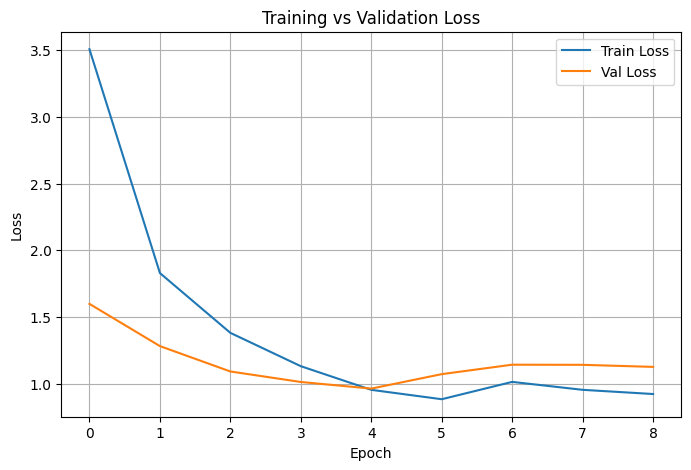

In [24]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.jpg')

plot_losses(train_losses, val_losses)

In [26]:
import shutil

shutil.make_archive('model', 'zip', '/kaggle/working/')


KeyboardInterrupt: 

In [ ]:
from IPython.display import FileLink
FileLink(r'model.zip')
